In [147]:
import numpy as np
import nibabel as nib
from google.colab import files


uploaded = files.upload()

KeyboardInterrupt: ignored

Dimensioni dell'array training prima dello swap:  (127, 207, 151)
Dimensioni dell'array label prima dello swap:  (127, 207, 151)
Dimensioni dell'array training dopo lo swap:  (207, 127, 151)
Dimensioni dell'array label dopo lo swap:  (207, 127, 151)


/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Dimensioni dell'array training dopo il resize:  (207, 128, 160)
Dimensioni dell'array label dopo il resize:  (207, 128, 160)


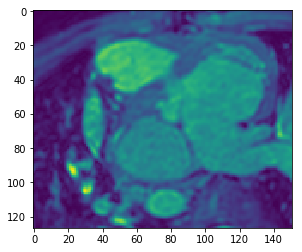

In [148]:
import numpy as np
import nibabel as nib
from google.colab import files
from PIL import Image
from matplotlib import pyplot as plt

#uploaded = files.upload()
#cargar
#img = nib.load('../content/training_axial_crop_pat0.nii')
#img1 = nib.load('../content/training_axial_crop_pat1.nii')

#a = np.array(img.dataobj)
#b = np.array(img1.dataobj)

#-------------------------------------------------------------

smooth = 1.
#img_rows = 128
img_rows = 128
#img_cols = 151
img_cols = 160


#plt.imshow(img, cmap=plt.cm.gray)
#plt.show()

#read image 3d
img_training = nib.load('../content/training_sa_crop_pat0.nii')
img_label = nib.load('../content/training_sa_crop_pat0-label.nii')

#create numpy array 
array_training = np.array(img_training.dataobj)
array_label = np.array(img_label.dataobj)

print("Dimensioni dell'array training prima dello swap: ",array_training.shape)
print("Dimensioni dell'array label prima dello swap: ",array_training.shape)
array_training = np.swapaxes(array_training,0,1)
array_label = np.swapaxes(array_label,0,1)
print("Dimensioni dell'array training dopo lo swap: ",array_training.shape)
print("Dimensioni dell'array label dopo lo swap: ",array_training.shape)


import matplotlib.pyplot as plt
plt.imshow(array_training[108,::])


#resized_array_training = np.resize(array_training, (127, 224, 160))
#resized_array_label = np.resize(array_label, (127, 224, 160))



#from scipy.ndimage import zoom
#resized_array_training = zoom(array_training, (1.08, 1, 1.06))
#resized_array_label= zoom(array_label, (1.08, 1, 1.06))
resized_array_training = zoom(array_training, (1, 1.007, 1.06))
resized_array_label= zoom(array_label, (1, 1.007, 1.06))

print("Dimensioni dell'array training dopo il resize: ", resized_array_training.shape)
print("Dimensioni dell'array label dopo il resize: ", resized_array_label.shape)

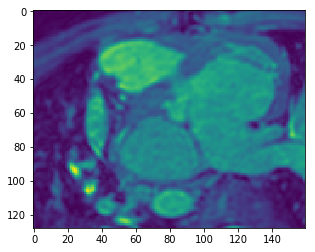

In [149]:
import matplotlib.pyplot as plt
plt.imshow(resized_array_training[108,:,:])


In [0]:
import os
from google.colab import drive
import numpy as np
from google.colab.patches import cv2_imshow
from keras import backend as K
from keras import layers
from keras.layers import Activation
from keras.layers import Input, Conv2D, ZeroPadding2D, MaxPooling2D, UpSampling2D, concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from PIL import Image
from keras.preprocessing.image import load_img


#array_training = array_training.reshape((1, array_training.shape[0], array_training.shape[1],1))
resized_array_training = resized_array_training.reshape((resized_array_training.shape[0], resized_array_training.shape[1], resized_array_training.shape[2],1))
resized_array_training = resized_array_training.astype('float32')


mean = np.mean(resized_array_training)
std = np.std(resized_array_training)

resized_array_training -= mean
resized_array_training /= std


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
  
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
  
def up_conv_block(input_tensor, kernel_size, filters, stage, block, strides=(1, 1)):
  filters1, filters2, filters3 = filters
  if K.image_data_format() == 'channels_last':
      bn_axis = 3
  else:
      bn_axis = 1
  up_conv_name_base = 'up' + str(stage) + block + '_branch'
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  x = UpSampling2D(size=(2, 2), name=up_conv_name_base + '2a')(input_tensor)

  x = Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(x)

  x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
  x = Activation('relu')(x)

  x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
  x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
  x = Activation('relu')(x)

  x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
  x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

  shortcut = UpSampling2D(size=(2, 2), name=up_conv_name_base + '1')(input_tensor)
  shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(shortcut)
  shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

  x = layers.add([x, shortcut])
  x = Activation('relu')(x)
  return x
  
def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x
  
def get_resnet(f=16, bn_axis=3, classes=1):
  
  input = Input((img_rows, img_cols, 1))
  x = ZeroPadding2D((4, 4))(input)
  x = Conv2D(f, (7, 7), strides=(2, 2), name='conv1')(x)
  x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D((3, 3), strides=(2, 2))(x)
  print("dimensione output primo strato: ", x.shape)

  x = conv_block(x, 3, [f, f, f * 2], stage=2, block='a', strides=(1, 1))
  x = identity_block(x, 3, [f, f, f * 2], stage=2, block='b')
  x2 = identity_block(x, 3, [f, f, f * 2], stage=2, block='c')
  print("dimensione output secondo strato: ", x.shape)

  x = conv_block(x2, 3, [f * 2, f * 2, f * 4], stage=3, block='a')
  x = identity_block(x, 3, [f * 2, f * 2, f * 4], stage=3, block='b')
  x3 = identity_block(x, 3, [f * 2, f * 2, f * 4], stage=3, block='d')
  print("dimensione output terzo strato: ", x.shape)

  x = conv_block(x3, 3, [f * 4, f * 4, f * 8], stage=4, block='a')
  x = identity_block(x, 3, [f * 4, f * 4, f * 8], stage=4, block='b')
  x4 = identity_block(x, 3, [f * 4, f * 4, f * 8], stage=4, block='f')
  print("dimensione output quarto strato: ", x.shape)

  x = conv_block(x4, 3, [f * 8, f * 8, f * 16], stage=5, block='a')
  x = identity_block(x, 3, [f * 8, f * 8, f * 16], stage=5, block='b')
  x = identity_block(x, 3, [f * 8, f * 8, f * 16], stage=5, block='c')
  print("dimensione output quinto strato: ", x.shape)

  x = up_conv_block(x, 3, [f * 16, f * 8, f * 8], stage=6, block='a')
  x = identity_block(x, 3, [f * 16, f * 8, f * 8], stage=6, block='b')
  x = identity_block(x, 3, [f * 16, f * 8, f * 8], stage=6, block='c')
  print("dimensione output sesto strato: ", x.shape)
  
  

  x = concatenate([x, x4], axis=bn_axis)

  x = up_conv_block(x, 3, [f * 16, f * 4, f * 4], stage=7, block='a')
  x = identity_block(x, 3, [f * 16, f * 4, f * 4], stage=7, block='b')

  x = identity_block(x, 3, [f * 16, f * 4, f * 4], stage=7, block='f')

  x = concatenate([x, x3], axis=bn_axis)

  x = up_conv_block(x, 3, [f * 8, f * 2, f * 2], stage=8, block='a')
  x = identity_block(x, 3, [f * 8, f * 2, f * 2], stage=8, block='b')
  x = identity_block(x, 3, [f * 8, f * 2, f * 2], stage=8, block='d')

  x = concatenate([x, x2], axis=bn_axis)

  x = up_conv_block(x, 3, [f * 4, f, f], stage=10, block='a', strides=(1, 1))
  x = identity_block(x, 3, [f * 4, f, f], stage=10, block='b')
  x = identity_block(x, 3, [f * 4, f, f], stage=10, block='c')

  x = UpSampling2D(size=(2, 2))(x)
  x = Conv2D(classes, (3, 3), padding='same', activation='sigmoid', name='convLast')(x)

  model = Model(input, x, name='resnetUnet')
  model.compile(optimizer=Adam(lr=3e-5), loss=dice_coef_loss,
                metrics=[dice_coef])
     # model.compile(optimizer=Adam(lr=3e-4), loss=dice_coef_loss,
      #          metrics=[dice_coef, 'accuracy', precision, recall, f1score])

  model.summary()
  return model

In [151]:
model = get_resnet(f=16, bn_axis=3, classes=1)

dimensione output primo strato:  (?, 32, 40, 16)
dimensione output secondo strato:  (?, 32, 40, 32)
dimensione output terzo strato:  (?, 16, 20, 64)
dimensione output quarto strato:  (?, 8, 10, 128)
dimensione output quinto strato:  (?, 4, 5, 256)
dimensione output sesto strato:  (?, 8, 10, 128)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 128, 160, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_15 (ZeroPadding2 (None, 136, 168, 1)  0           input_15[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 65, 81, 16)   800         zero_padding2d_15[0][0]          
__________

In [153]:
print("Dimensione resized array training ",resized_array_training.shape)
print("Dimensione resized array label ",resized_array_label.shape)

x_train = resized_array_training[0:144]
x_test = resized_array_training[145:207]
y_train = resized_array_label[0:144]
y_test = resized_array_label[145:207]


print("Dimensione x train",x_train.shape)
print("Dimensione x test ",x_test.shape)
print("Dimensione y train",y_train.shape)
print("Dimensione y test ",y_test.shape)





results = model.fit(x_train, y_train, batch_size=16, epochs=3)

Dimensione resized array training  (207, 128, 160, 1)
Dimensione resized array label  (207, 128, 160)
Dimensione x train (144, 128, 160, 1)
Dimensione x test  (62, 128, 160, 1)
Dimensione y train (144, 128, 160)
Dimensione y test  (62, 128, 160)
Epoch 1/3
144/144 [==============================] - 84s 585ms/step - loss: -0.5698 - dice_coef: 0.5698
Epoch 2/3
144/144 [==============================] - 1s 9ms/step - loss: -0.6127 - dice_coef: 0.6127
Epoch 3/3
144/144 [==============================] - 1s 9ms/step - loss: -0.6656 - dice_coef: 0.6656


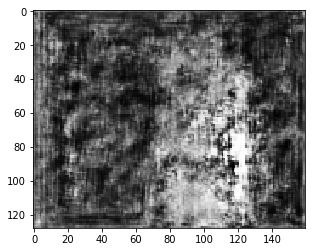

In [162]:
import matplotlib.pyplot as plt
predicted_image = model.predict(x_test, verbose = 0)
image = (predicted_image[61][:, :, 0] * 255.).astype(np.uint8)
img = Image.fromarray(image)
plt.imshow(img, cmap=plt.cm.gray)
plt.show()